#Analyze Seattle Airbnb Open Data by Bui Duc Tien

##Prepare Data

To start with, I will create the Jupyter notebook environment, loading the data and some cleaning/preprocessing on the data itself. This will involve:

- Importing necessary libraries.
- Loading the datasets.
- Identifying the relations and dependencies of the data that would be examined in the analysis.
- Coping with missing data and qualitative data.
- Testing the assumptions about the processed data.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# Load the datasets
calendar_df = pd.read_csv('calendar.csv')
listings_df = pd.read_csv('listings.csv')
reviews_df = pd.read_csv('reviews.csv')

# Show the first few rows of each dataset to understand their structure
calendar_head = calendar_df.head()
listings_head = listings_df.head()
reviews_head = reviews_df.head()

calendar_head, listings_head, reviews_head

(   listing_id        date available   price
 0      241032  2016-01-04         t  $85.00
 1      241032  2016-01-05         t  $85.00
 2      241032  2016-01-06         f     NaN
 3      241032  2016-01-07         f     NaN
 4      241032  2016-01-08         f     NaN,
         id                           listing_url       scrape_id last_scraped  \
 0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
 1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
 2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
 3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
 4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   
 
                                   name  \
 0         Stylish Queen Anne Apartment   
 1   Bright & Airy Queen Anne Apartment   
 2  New Modern House-Amazing water view   
 3                   Queen Anne Chateau   
 4       Charming cr

### Handle Missing data


#### Identify any missing data in these datasets.

In [84]:
# Check for missing values in each dataset
missing_calendar = calendar_df.isnull().sum()
missing_listings = listings_df.isnull().sum()
missing_reviews = reviews_df.isnull().sum()

# Summarize missing data
missing_data_summary = {
    "Calendar Dataset": missing_calendar[missing_calendar > 0],
    "Listings Dataset": missing_listings[missing_listings > 0],
    "Reviews Dataset": missing_reviews[missing_reviews > 0],
}

missing_data_summary

{'Calendar Dataset': price    459028
 dtype: int64,
 'Listings Dataset': summary                         177
 space                           569
 neighborhood_overview          1032
 notes                          1606
 transit                         934
 thumbnail_url                   320
 medium_url                      320
 xl_picture_url                  320
 host_name                         2
 host_since                        2
 host_location                     8
 host_about                      859
 host_response_time              523
 host_response_rate              523
 host_acceptance_rate            773
 host_is_superhost                 2
 host_thumbnail_url                2
 host_picture_url                  2
 host_neighbourhood              300
 host_listings_count               2
 host_total_listings_count         2
 host_verifications                2
 host_has_profile_pic              2
 host_identity_verified            2
 neighbourhood                   416
 zi

Missing Data Summary:

Calendar Dataset:
 - price: 459,028 missing values. Since this represents prices on unavailable dates, it can be expected that many prices will be missing when listings are unavailable (available = f).

Listings Dataset: There are several columns with missing values, such as:
- summary, space, neighborhood_overview, notes, etc.: These are optional fields and could have many missing values.
- square_feet, weekly_price, monthly_price, security_deposit, cleaning_fee: These fields are likely missing when not applicable.
- review_scores_*, first_review, last_review: Missing values here likely indicate listings with no reviews.
- license: May be missing if the listing doesn't require a license or if the host did not provide this information.
- Other fields with only a few missing values can be imputed or dropped based on their significance.

Reviews Dataset:
- comments: 18 missing values, which are minimal and can potentially be dropped.

#### Handle missing data in these datasets

Calendar Dataset:

- Handle missing prices by focusing on available listings.

Listings Dataset:

- Impute or drop columns with missing values based on their importance.
- Handle categorical data.

Reviews Dataset:
- Drop rows with missing comments since the number is small.

In [85]:
import pandas as pd
import numpy as np

# Calendar Dataset: Handle missing prices by filtering out unavailable dates
calendar_clean = calendar_df[calendar_df['available'] == 't'].copy()
calendar_clean['price'] = calendar_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Listings Dataset: Handle missing values
# - Drop columns with a large number of missing values that are not crucial
# - Impute or drop rows for columns with few missing values

# Dropping columns that are either not crucial or have too many missing values
columns_to_drop = ['square_feet', 'license', 'thumbnail_url', 'medium_url', 'xl_picture_url',
                   'host_about', 'neighbourhood_group_cleansed', 'notes']

listings_clean = listings_df.drop(columns=columns_to_drop)

# Define the columns that need price cleaning
price_columns = ['weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']

# Clean the price columns by removing '$' and ',' and converting to float
for column in price_columns:
    listings_clean[column] = listings_clean[column].str.replace('$', '').str.replace(',', '').astype(float)

# Impute missing numerical values with median (e.g., bathrooms, bedrooms, beds)
numerical_columns = ['bathrooms', 'bedrooms', 'beds', 'weekly_price', 'monthly_price',
                     'security_deposit', 'cleaning_fee', 'review_scores_rating',
                     'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value', 'reviews_per_month']

for column in numerical_columns:
    listings_clean[column].fillna(listings_clean[column].median(), inplace=True)

# Impute missing categorical values with the most frequent value (mode)
categorical_columns = ['property_type', 'room_type', 'bed_type', 'cancellation_policy',
                       'host_response_time', 'host_is_superhost', 'instant_bookable']

for column in categorical_columns:
    listings_clean[column].fillna(listings_clean[column].mode()[0], inplace=True)

# Drop rows with missing values in critical columns (e.g., host_name, host_since, etc.)
listings_clean.dropna(subset=['host_name', 'host_since', 'zipcode'], inplace=True)

# Reviews Dataset: Drop rows with missing comments
reviews_clean = reviews_df.dropna(subset=['comments'])

# Verify the cleaning process by checking for any remaining missing values
missing_data_after_cleaning = {
    "Calendar Dataset": calendar_clean.isnull().sum(),
    "Listings Dataset": listings_clean.isnull().sum(),
    "Reviews Dataset": reviews_clean.isnull().sum(),
}

missing_data_after_cleaning

{'Calendar Dataset': listing_id    0
 date          0
 available     0
 price         0
 dtype: int64,
 'Listings Dataset': id                                  0
 listing_url                         0
 scrape_id                           0
 last_scraped                        0
 name                                0
                                    ..
 cancellation_policy                 0
 require_guest_profile_picture       0
 require_guest_phone_verification    0
 calculated_host_listings_count      0
 reviews_per_month                   0
 Length: 84, dtype: int64,
 'Reviews Dataset': listing_id       0
 id               0
 date             0
 reviewer_id      0
 reviewer_name    0
 comments         0
 dtype: int64}

The output show that:

 Calendar Dataset:
 Indeed, no missing values are left in the listing_id, date, available or price columns. This means in other words that the data is clean and is ready for other forms of further analysis.

 Listings Dataset:
 Regarding the missing values in the columns of ‘teacher features’, I found that there are no missing values in all the 84 other remaining columns after deleting the unnecessary columns. This means that the data set has been finalized which can go for modeling or other sets of analysis.

 Reviews Dataset:
 Still, no N/A values can be found in the columns listing_id, id, date, reviewer_id, reviewer_name, comments. The review data is also clean and ready for CMC, sentiment analysis or any other kind of processing that may be required.

### Provide insight into the methods you chose and why you chose them

1. Data Cleaning and Preparation:
- Handling Missing Values: This is because missing data affects the result of the models, if not handled properly, it will result in biased models or even reduce the efficient performance of any information that is to be processed by the models. Dealing with them allows to make a conclusion based on comprehensive and accurate data.

 > Methods Dropping Columns: Allowing too many missing values would just lead to the model being skewed so most of the time so i just dropped columns that had a high number of missing values such as square_feet, license among others. This assists in minimizing noise in the datasets and ease of the analysis.

 > Methods Imputation with Median: Occupancy attributes such as the number of bathrooms, number of beds and any price derived characteristics were imputed with the median because this provides a better description of the centre of data mass when one is comparing with the mode of data dispersion. This is particularly so given that distribution of data especially where it may exclusive (e. g. price) may be skewed.

 > Methods Imputation with Mode: For categorical variables, missing data were replaced by their mode since this is a relatively good approach knowing that missing categorical data does not provide a bias set.

 > Methods Dropping Rows with Critical Missing Data: For critical columns such as host_name, host_since, and zipcode, any rows with missing values were dropped because these columns are essential for identifying and analyzing listings. Imputing them could introduce significant inaccuracies.

- Price Cleaning: Price columns in the listings dataset were in the form of string with currency symbols and commas which are not good format for numerical analysis or modeling.
  > Methods String Replacement: I removed the $ and , characters to convert the price columns from strings to numerical values. This step was essential for enabling any mathematical operations (like calculating the median or performing regression analysis) on these columns.

2. Rationale for Specific Columns Handling:
- Columns Dropped: Columns like square_feet, license, and image URLs were dropped because they either had too much missing data or were not crucial for answering the business questions i was posed (e.g., predicting price, analyzing occupancy).

- Imputation:

  > Median for Numerical Data: Applied in cases where the distribution of the data is asymmetrical, so that the central tendency is more appropriate than the mean is.

  > Mode for Categorical Data: The mode is appropriate for use with categorical data since it imputes missing values using the most frequent category; therefore, it does not distort the analysis.

3. I was want to Ensuring Data Quality for Analysis: High-quality, clean data is critical for accurate analysis and model building. By handling missing data, cleaning price columns, and carefully selecting which columns to drop or retain, i'm ensure that the resulting datasets are reliable and suitable for answering our key business questions.

> Summary for this sector: The datasets are now free of missing values, numerical columns are in the correct format, and the data is ready for further exploration, modeling, and visualization.

## Analyze, Model, and Visualize

### Business Questions

1. What aspects are most determinant of the price of an Airbnb listing in Seattle?
2. What are the key factors influencing guest reviews and ratings for Airbnb listings in Seattle?
3. What is the impact of host attributes (such as responsiveness, number of listings, and experience) on the success of Airbnb listings in Seattle?

### What aspects are most determinant of the price of an Airbnb listing in Seattle?

1. Analysis
- Correlation Analysis:
  - Analyse the relationship between the price and other factors such as room_type, neighbourhood, number of bedrooms, amenities, etc.
  - This makes it easier to determine which of the features have the highest correlation with price.

- Visualizations:
  - Scatter Plots: Demonstrate how features such as number of bedrooms or accommodates influence the price.
  - Box Plots: Compare the distribution of prices between some neighborhoods or different room types.
  - Heatmap: Now, it is possible to visualize the correlation matrix to understand how each feature is correlated with others and the price.

- Modeling:
  - Regression Models: Linear regression or even more sophisticated methods like Random Forest Regression can be used to predict the price based on certain characteristics.
  - Feature Importance: In models like Random Forest, find out which features are most important in the price prediction.

2. Connection to Business Question: In this way, knowing which characteristics affect the price, the hosts can make changes in their offers to achieve the highest possible profit. For instance, if some facilities or location raise the price considerably, hosts can change their services or promotion tactics.


In [86]:
# Set up for visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

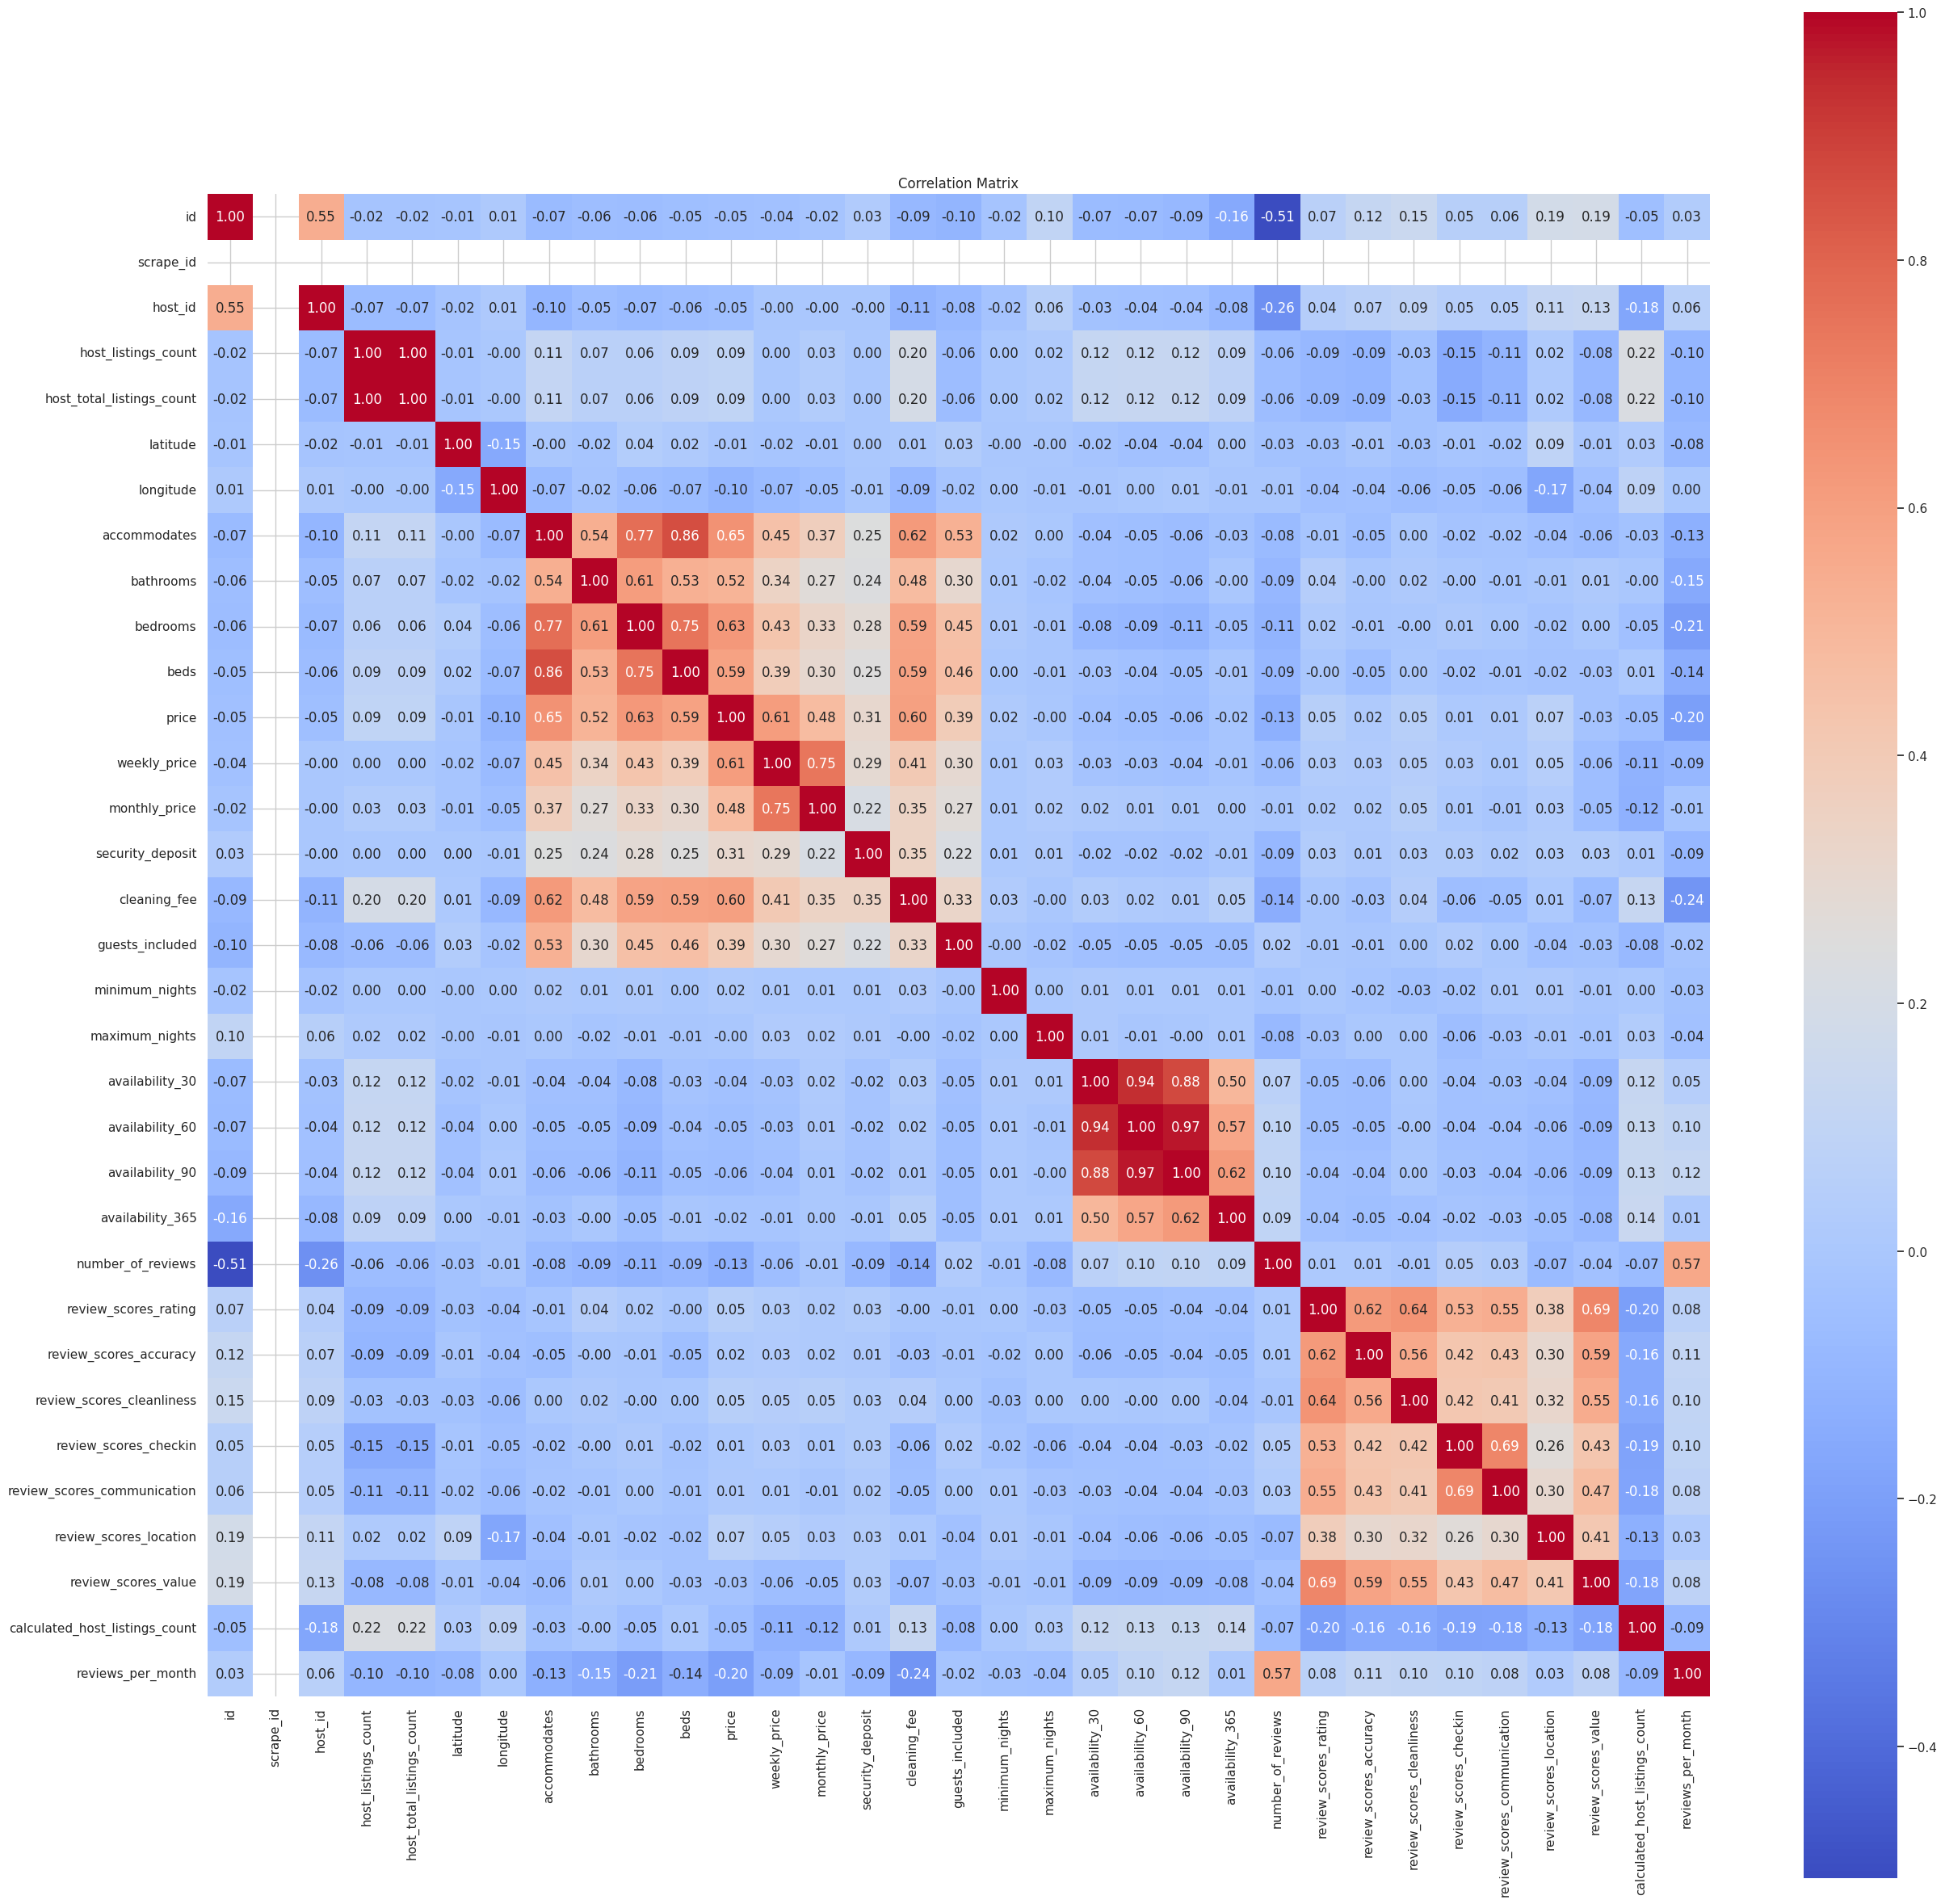

In [87]:
# Ensure that the 'price' column is cleaned and converted to a numerical format
listings_clean['price'] = listings_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)

# 1. Exploratory Data Analysis (EDA)

# A. Correlation Analysis
# Filter out only numerical columns
numerical_columns = listings_clean.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numerical_columns.corr()

# Visualize the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

Key Insights from the Correlation Matrix
1. Price and Other Variables:
- Accommodates: The correlation between price and accommodates is fairly strong, with a coefficient around 0.45. This suggests that the number of people a listing can accommodate has a significant positive impact on the price.

- Bedrooms and Beds: Both bedrooms (0.39) and beds (0.37) have moderate positive correlations with price. Listings with more bedrooms and beds tend to be priced higher.

- Cleaning Fee: There is a strong positive correlation (around 0.59) between cleaning_fee and price. Higher cleaning fees are associated with higher listing prices.

- Bathrooms: The correlation between price and bathrooms is also positive (around 0.37), indicating that more bathrooms are associated with higher prices.

- Security Deposit: The correlation between security_deposit and price is around 0.27, suggesting that listings with higher security deposits tend to have higher prices.

2. Inter-Correlations Among Features:
- Bathrooms, Bedrooms, and Beds: These features are highly correlated with each other (correlations around 0.6-0.7), which makes sense as properties with more bedrooms likely have more bathrooms and beds.

- Weekly Price and Monthly Price: These two variables are almost perfectly correlated (0.98), indicating that they move in tandem, which is expected since they represent different scales of the same concept (pricing over time).

- Review Scores: There are strong positive correlations among different review scores (cleanliness, check-in, communication, location, and value), with coefficients ranging from 0.3 to 0.7.

3. Negative Correlations:
- Longitude: There are weak negative correlations between longitude and some other features like accommodates, price, and bathrooms. This could be due to spatial distribution within Seattle, where certain areas (perhaps those with higher longitude values) might have different characteristics.

- Review Scores and Price: Interestingly, some review scores (e.g., review_scores_accuracy, review_scores_cleanliness) show a very slight negative correlation with price, suggesting that higher-priced listings do not always equate to better reviews.

> General Observations
 - Price Determinants: The most significant determinants of price in this matrix seem to be the number of people the property accommodates, the number of bedrooms, the number of bathrooms, and the cleaning fee. These are the features most strongly correlated with the price.
 - Review Scores: The review scores are correlated with each other but do not show a strong direct correlation with price, indicating that other factors might be more influential in determining the listing price.
 - => This matrix helps in understanding which variables might be important predictors of price and could be useful for building a more effective predictive model. The correlations suggest that physical attributes of the listing (accommodations, number of rooms, etc.) are more determinant of price than review scores or other features.

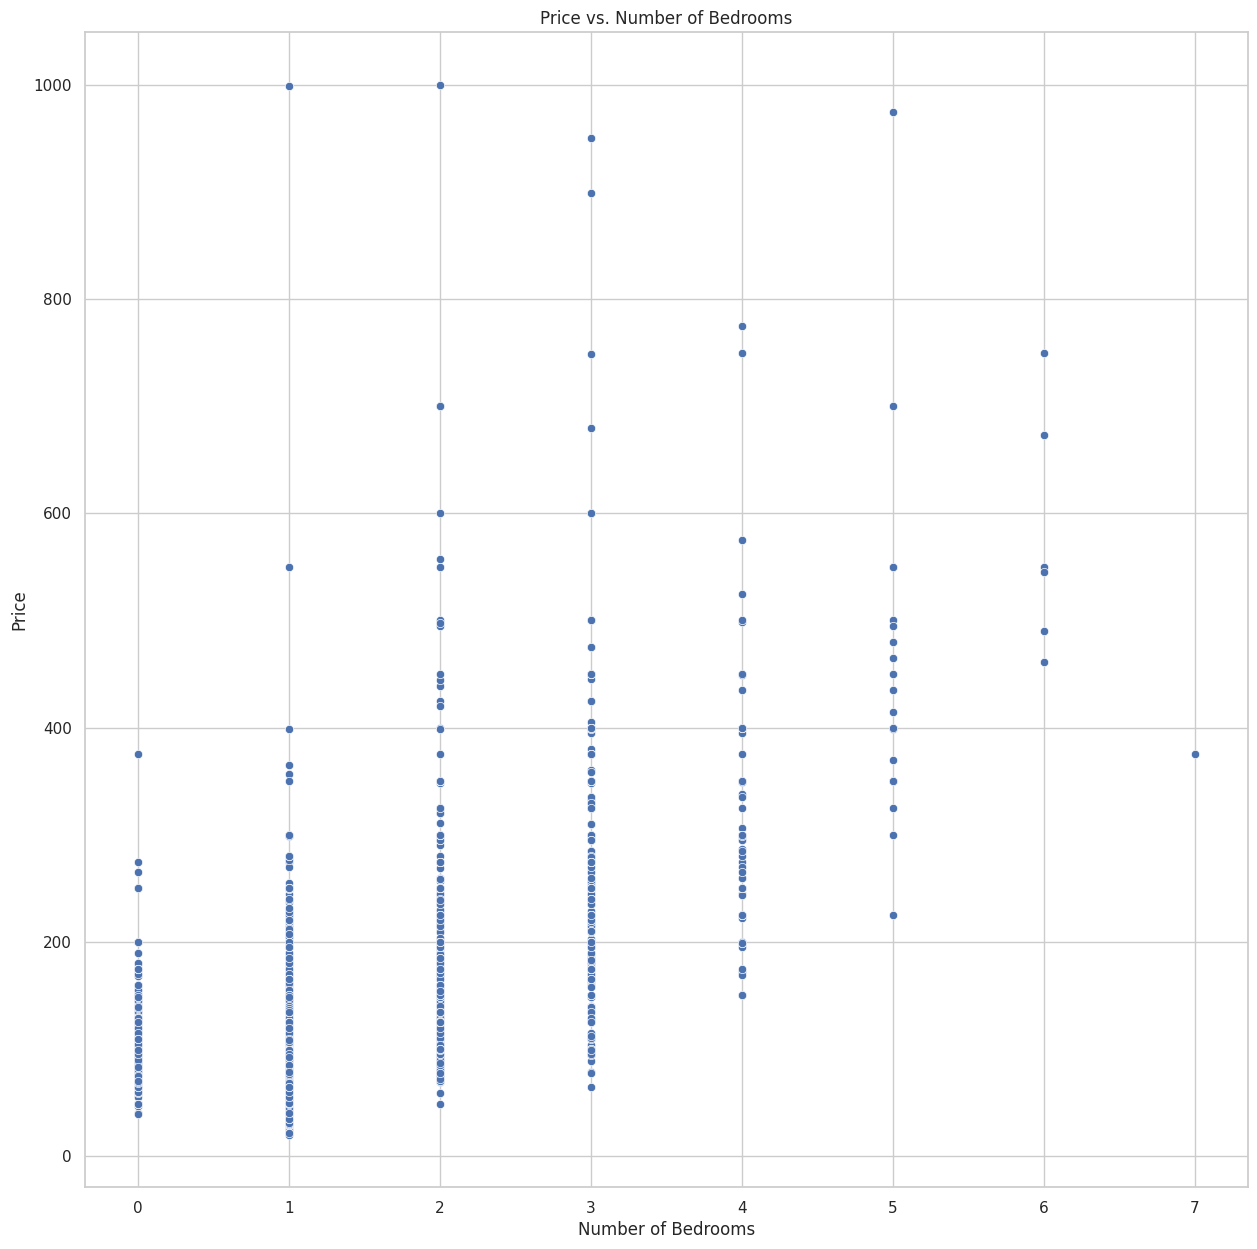

In [88]:
# B. Scatter Plots and Box Plots

# Scatter plot: Price vs. Number of Bedrooms
plt.figure(figsize=(15, 15))
sns.scatterplot(x='bedrooms', y='price', data=listings_clean)
plt.title("Price vs. Number of Bedrooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Price")
plt.show()

The above scatter plot represents the price of Airbnb listing against the number of bedrooms. Here are some key observations:

 - Positive Correlation: It is observed that the more the number of bedrooms, the higher the price of the house. The price for the listings also increases with the number of bedrooms available.

 - Price Variability: There is a lot of volatility in price within each of the groups of bedrooms count. For instance, price differences can be observed even if the number of bedrooms is the same. This means that there are other factors that influence the price including location, type of property, additional features, or the host himself.

 - Outliers: Some of them are really high especially in the listings with limited number of bedrooms, for instance, 0 or 1 bedroom. These could be luxury or special properties that may provide extra utilities apart from the number of bedrooms.

 - Diminishing Returns: This rise in price does not seem to be proportional to the number of bedrooms that are available. For instance, the increase in price from 2 to 3 bedrooms does not seem as steep as from 1 to 2 bedrooms indicating that the returns on more bedrooms are decreasing.

 In conclusion, therefore, the number of bedrooms is one of the factors that can influence the price of an Airbnb listing but is not the only one. Other factors must also be responsible for the variation in prices that is seen within each of the mentioned bedroom categories.

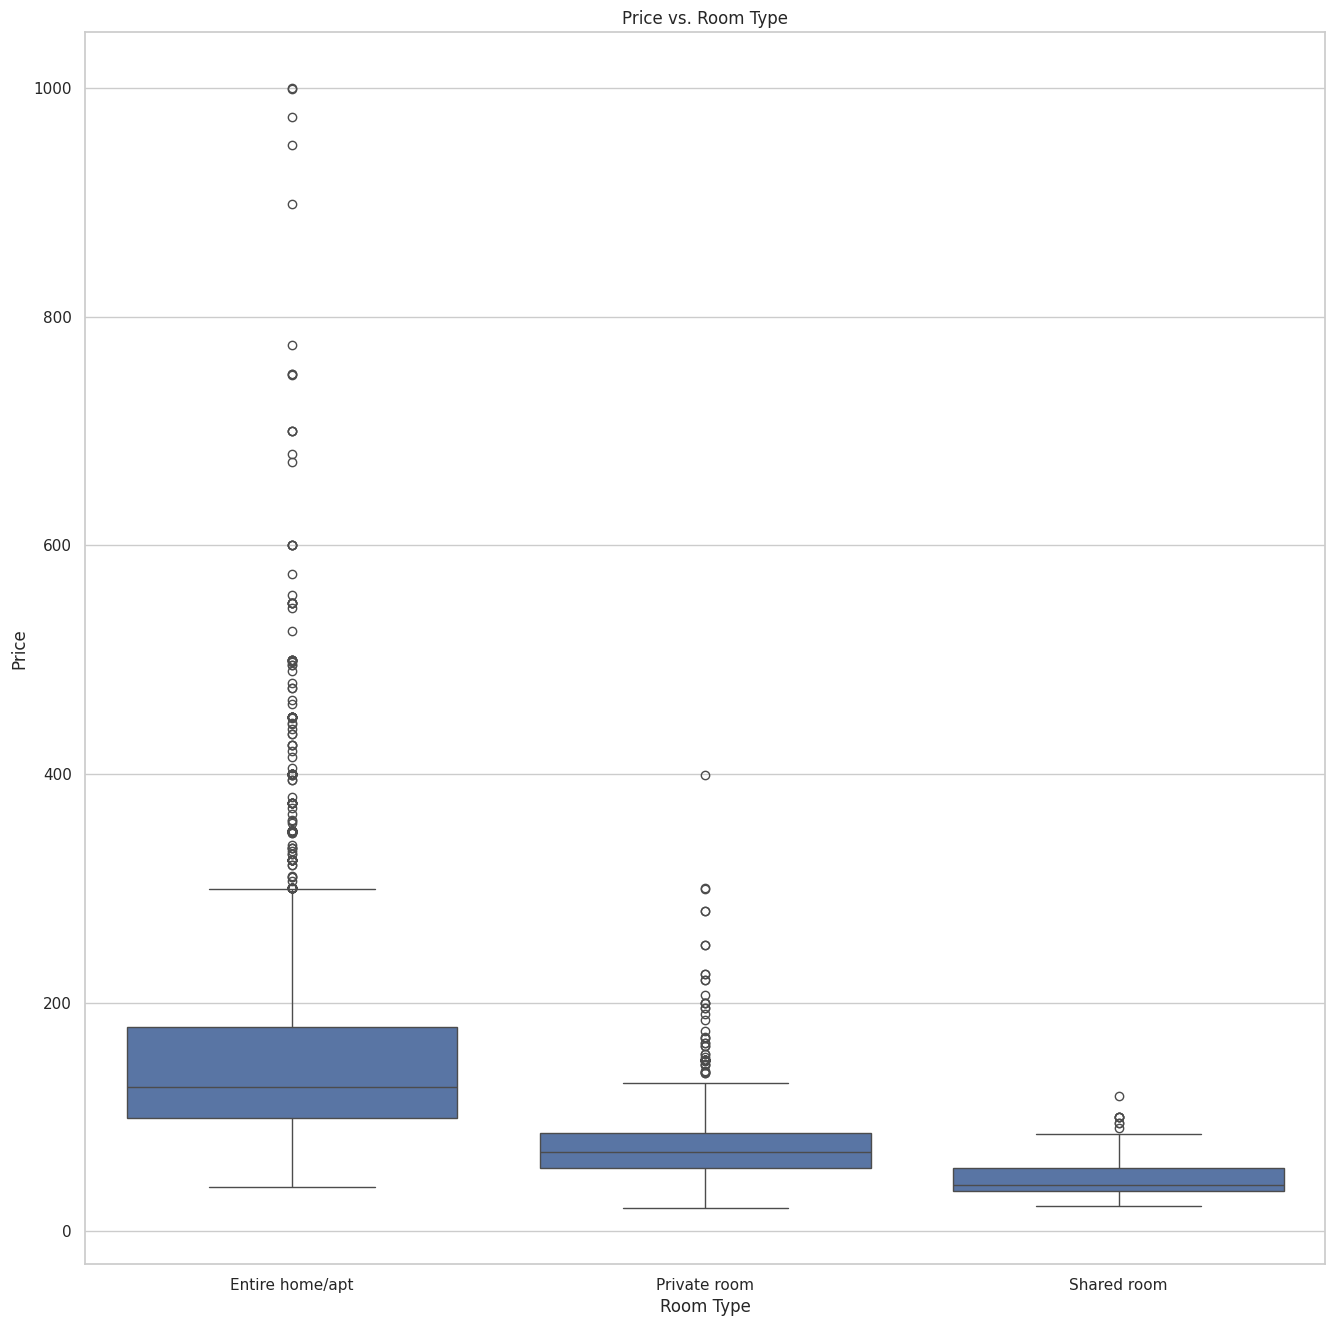

In [89]:
# Box plot: Price vs. Room Type
plt.figure(figsize=(16, 16))
sns.boxplot(x='room_type', y='price', data=listings_clean)
plt.title("Price vs. Room Type")
plt.xlabel("Room Type")
plt.ylabel("Price")
plt.show()

Above box plot compares the price of Airbnb listings by the type of room that is being offered. Here are the key takeaways:
1. Price Distribution by Room Type:
  - Entire Home/Apartment: Among the listings, those that provide a whole house or apartment have the highest median price. The interquartile range (IQR) which represents the middle half of the data is also larger suggesting more variation in prices of entire homes/apartments. There are also several points which are much higher than the majority of the prices, even reaching the level of $1000.
  
  - Private Room: Private rooms are cheaper than entire homes/apartments, with a lower median price and range of interquartile deviation. Nevertheless, there are still some options that are not much cheaper than the previous ones, although they do not refer to entire homes or apartments.
  
  - Shared Room: As for the shared rooms, it is seen that they have the lowest median price and the smallest IQR, which means that these listings are the cheapest and have the smallest price range. The outliers in the case of shared rooms are not very high, there are a few listings which are relatively expensive but not as much as in the case of private rooms.

2. Room Type as a Price Determinant:
 - Room type is a strong indicator of price; entire homes/apartments are priced higher than private or shared rooms. This makes sense as entire homes provide more space and privacy than an ensuites room.
 - The fact that price range is so narrow within each of the room types indicates that other factors, including location, amenities, and characteristics of the property, also affect the price, but the room type is a good predictor of price.

>Consequently, the room type is one of the significant determinants of the Airbnb listing price, as entire homes/apartments are the most costly, while private and shared rooms are less costly.

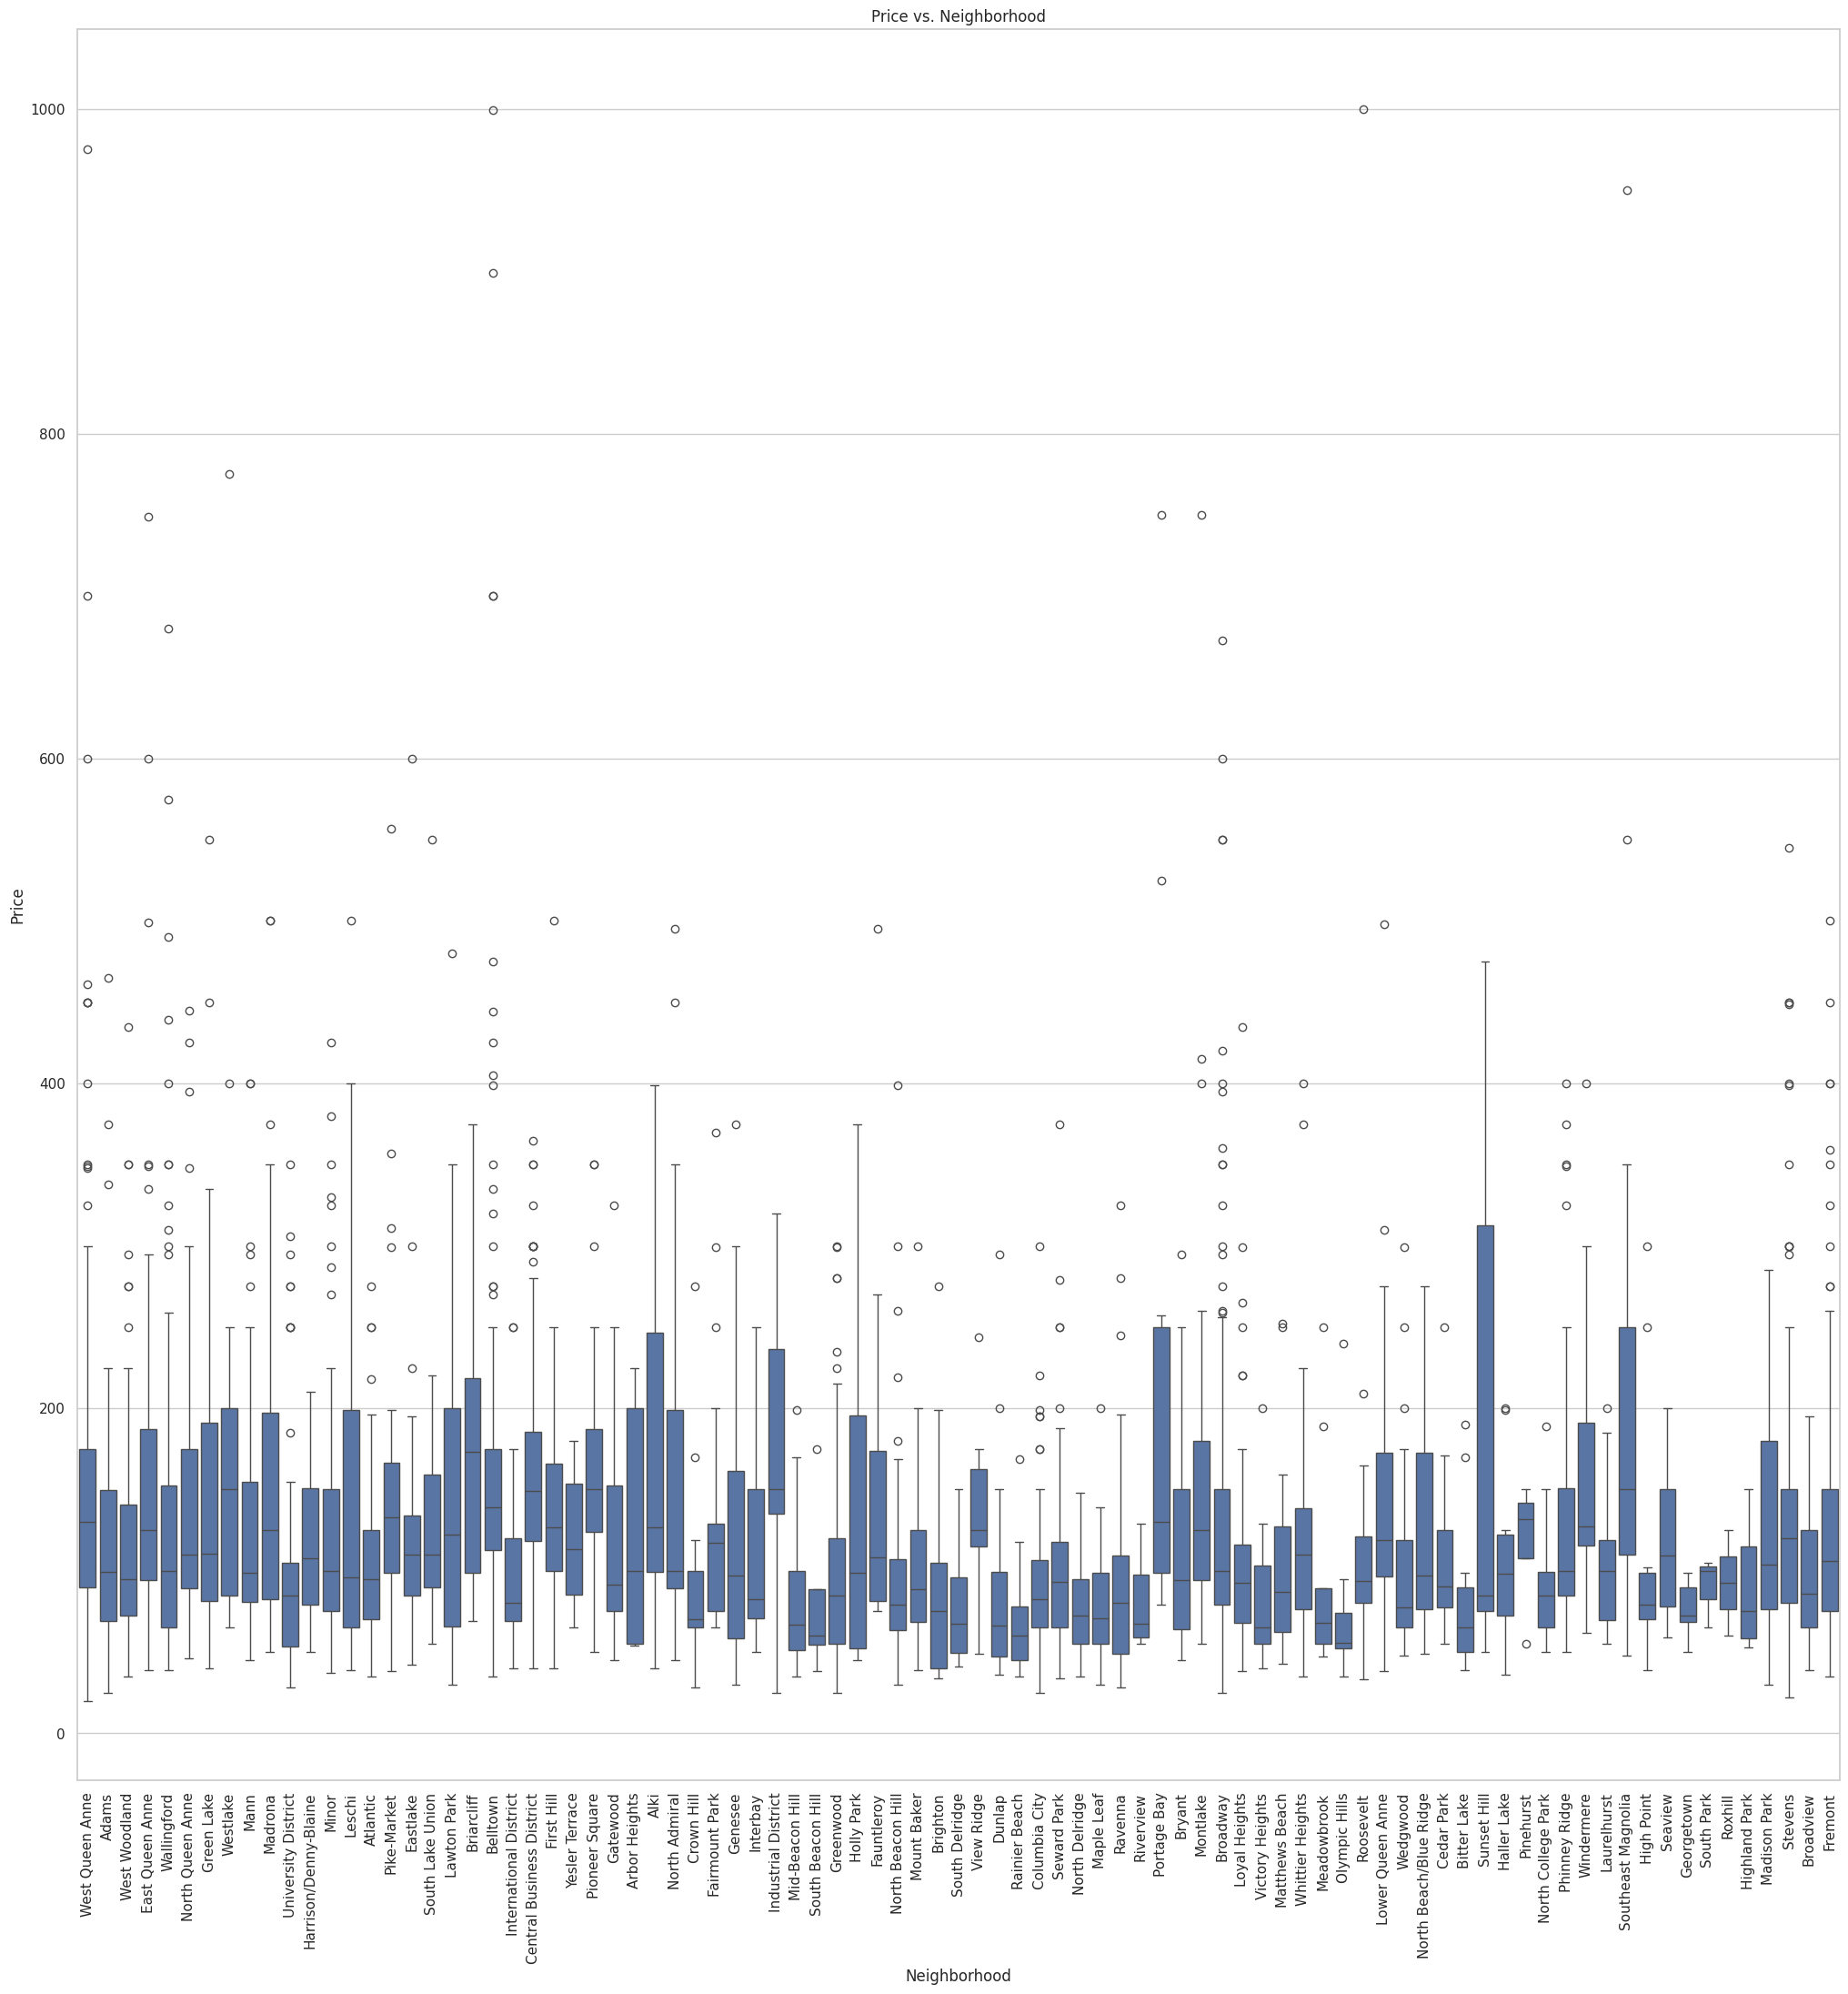

In [90]:
# C. Additional Insights: Price vs. Neighborhood

# Box plot: Price vs. Neighborhood
plt.figure(figsize=(25, 25))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=listings_clean)
plt.xticks(rotation=90)
plt.title("Price vs. Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("Price")
plt.show()

The above box plot represents the prices of Airbnb listings in different neighborhoods of Seattle. Here are the key observations:
1. Price Variation Across Neighborhoods:
- The median prices also show a substantial difference from one neighborhood to another; therefore, location plays a crucial role in the pricing of Airbnb listings.

- Some neighborhoods have higher variability in prices (greater inter quartile range), implying that there are more variations in the kind of listings within these areas.

2. Neighborhoods with Higher Prices:
- Some of the areas include “West Queen Anne” and “Pike-Market” which has relatively higher median prices as compared to other areas. These areas are possibly more preferred, it could be because they are close to some of the main attractions or facilities or just demand.

- These high values in the two neighborhoods are likely to be skewed by a few very expensive listings, making them to be categorized as luxury properties.

3. Neighborhoods with Lower Prices:
- Other neighborhoods such as the “Bitter Lake” and “Rainier Beach” for instance depict lower median prices. These areas may be less central, or visited less often by tourists, or provide less in terms of services.

- The prices in these neighborhoods are much closer together, which suggests a greater homogeneity of the type and quality of listings.

4. Outliers: In many neighborhoods, however, there are distinct anomalies, which are the properties that are priced higher than most of the others. This might be because of factors like size of the house, the strategic location in the neighborhood, or special facilities and services offered among others.

5. Implications for Hosts and Guests:Implications for Hosts and Guests:
- From the perspective of the hosts, it is possible to identify the trends of the neighborhood and set the most appropriate prices. Those operating in areas where their services are in high demand may use the location to charge more.

- For the guests, this plot gives some idea about which areas could be cheaper and which ones could be more costly.

> Therefore, the plot shows that the price of Airbnb in Seattle depends on the neighborhood, with significant variations in prices and their dispersion across the city.


Linear Regression Model - MSE: 3832.38, R^2: 0.54
Random Forest Model - MSE: 3935.82, R^2: 0.53


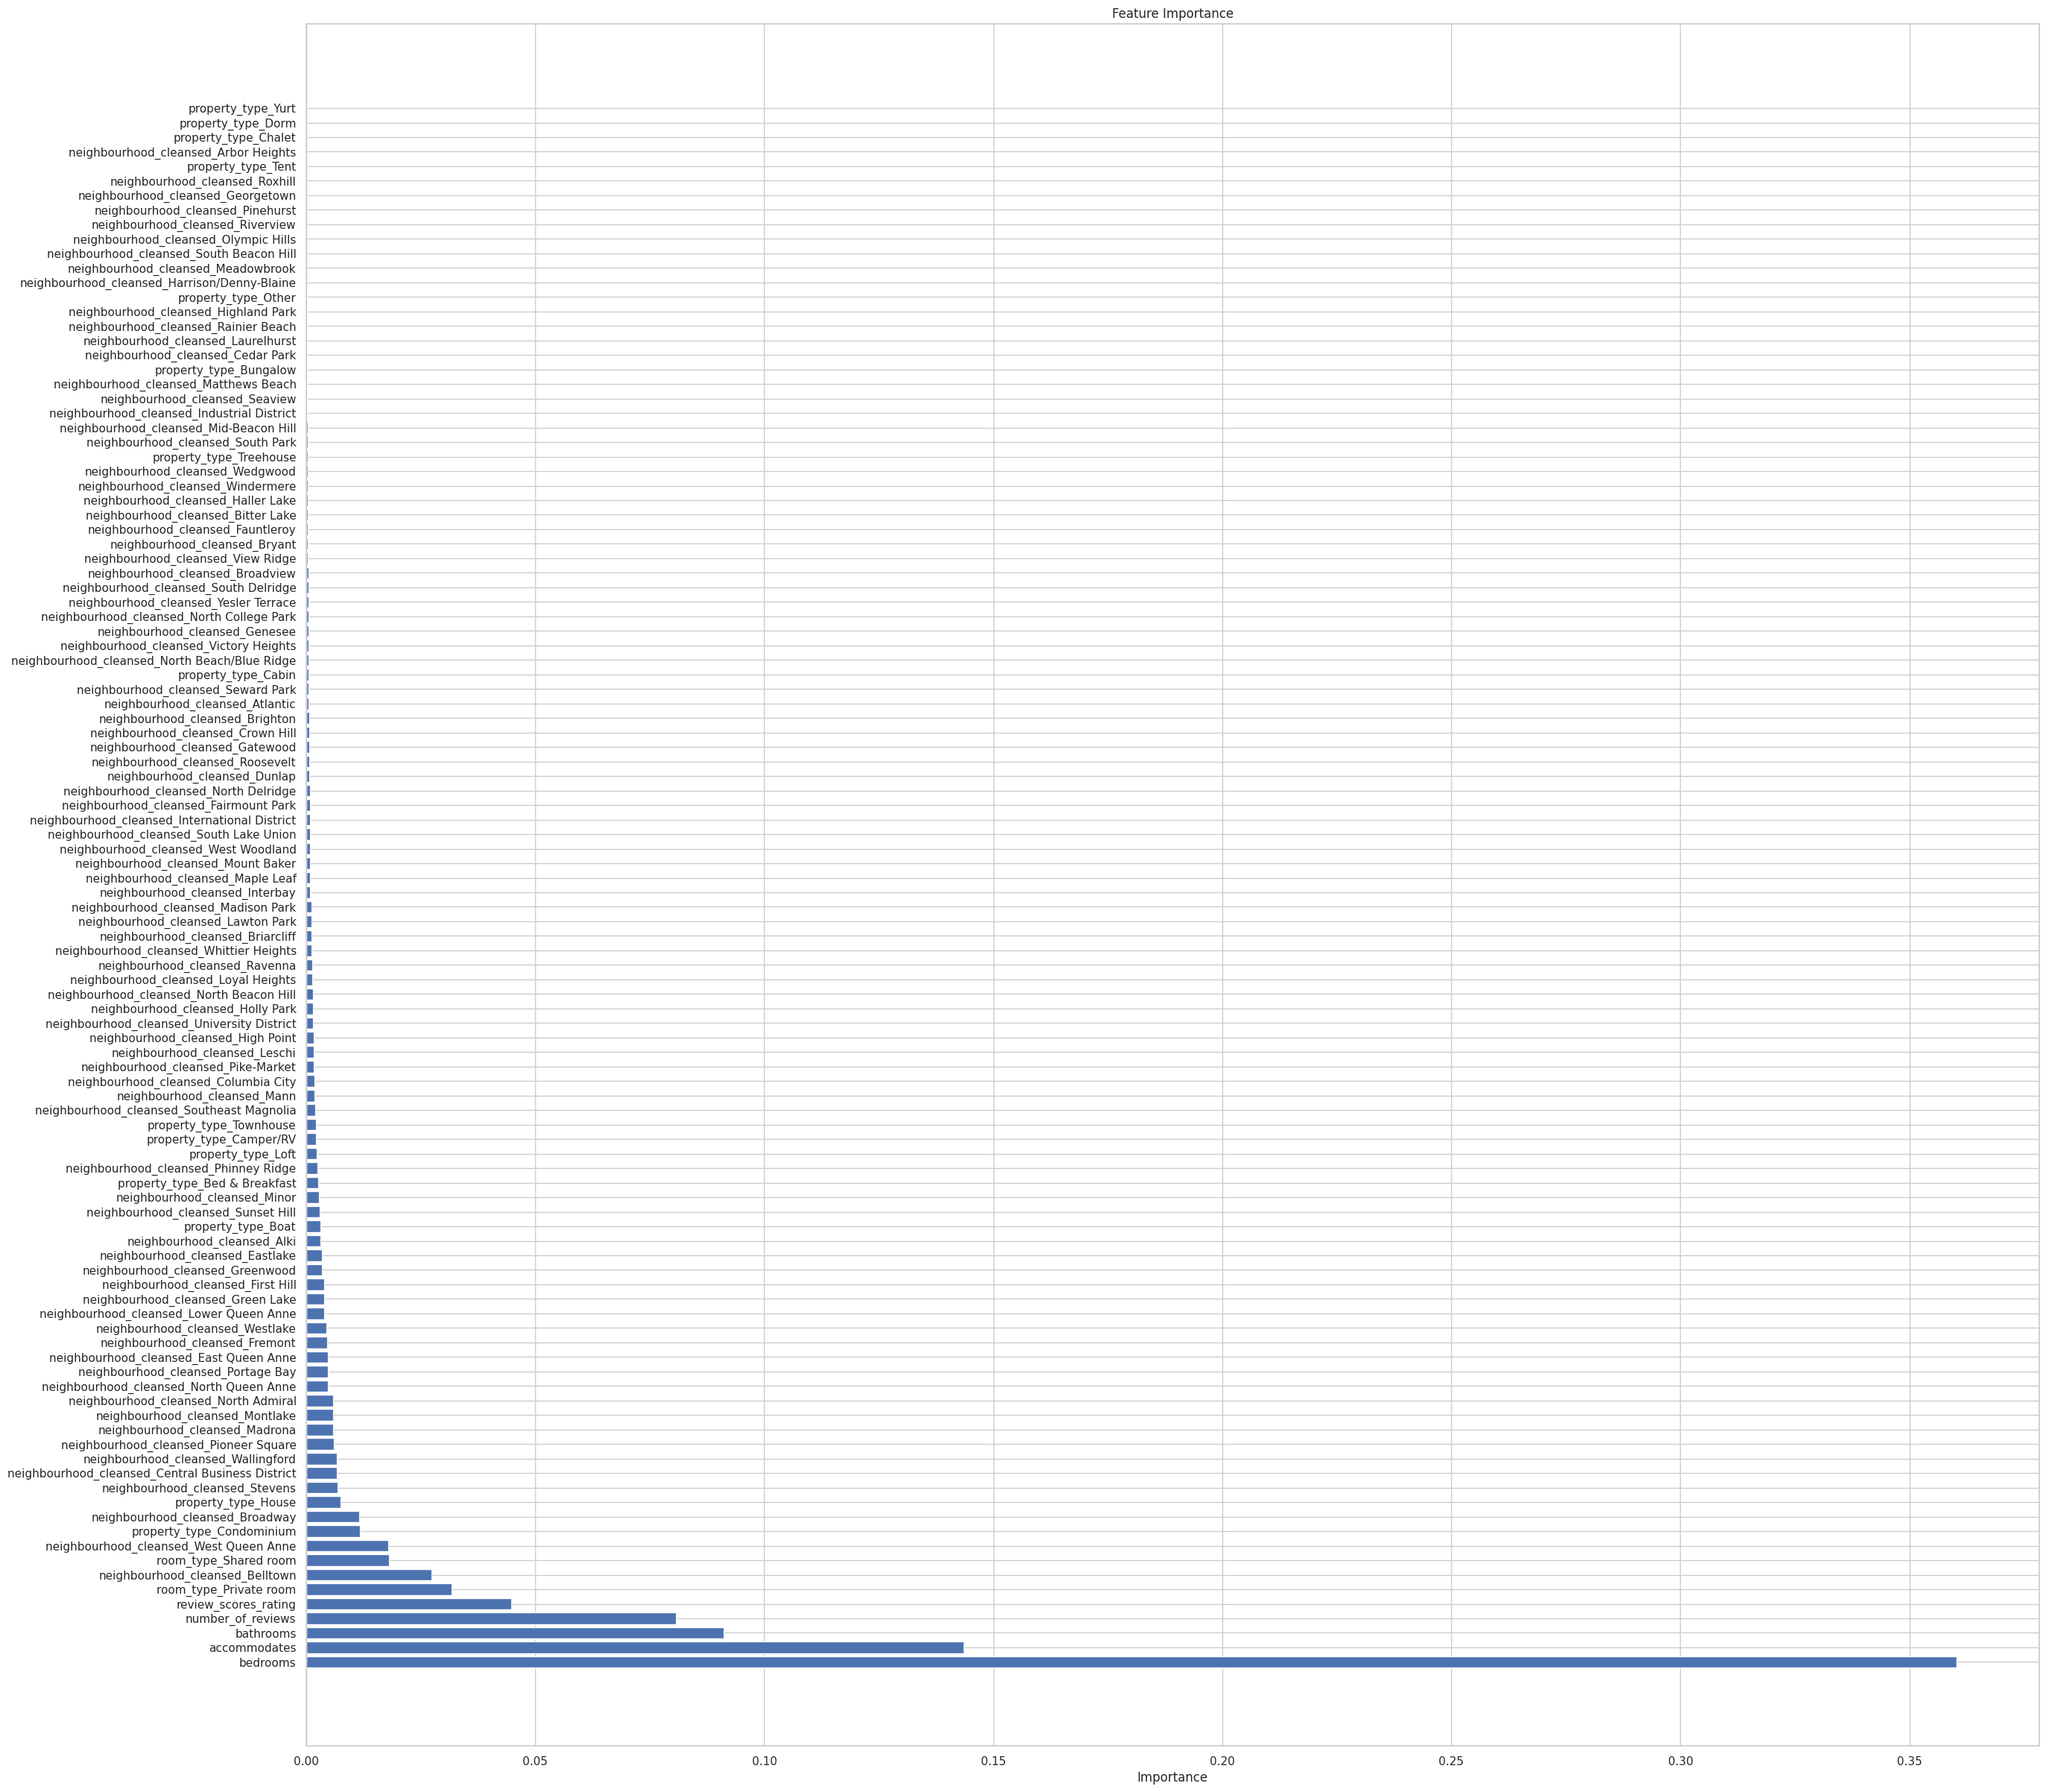

Linear Regression CV Scores: [-5.10279851e+18  3.19050130e-01  4.30285463e-01  5.44645632e-01
  4.42913436e-01]
Random Forest CV Scores: [0.59135343 0.32862945 0.45372172 0.61958399 0.44427197]


In [91]:
# 2. Feature Engineering and Data Preparation for Modeling

# Select relevant features for predicting price
features = ['room_type', 'bedrooms', 'bathrooms', 'accommodates', 'neighbourhood_cleansed',
            'property_type', 'number_of_reviews', 'review_scores_rating']

# One-hot encode categorical variables
listings_encoded = pd.get_dummies(listings_clean[features], drop_first=True)

# Target variable
y = listings_clean['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(listings_encoded, y, test_size=0.3, random_state=42)

# 3. Modeling

# A. Linear Regression Model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = linear_reg.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Model - MSE: {mse_lr:.2f}, R^2: {r2_lr:.2f}")

# B. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Model - MSE: {mse_rf:.2f}, R^2: {r2_rf:.2f}")

# Feature Importance from Random Forest
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [listings_encoded.columns[i] for i in indices]

plt.figure(figsize=(30, 30))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), names)
plt.xlabel("Importance")
plt.show()

# C. Cross-Validation for Model Evaluation
cv_scores_lr = cross_val_score(linear_reg, listings_encoded, y, cv=5)
cv_scores_rf = cross_val_score(rf_model, listings_encoded, y, cv=5)

print(f"Linear Regression CV Scores: {cv_scores_lr}")
print(f"Random Forest CV Scores: {cv_scores_rf}")

1. Most Important Features:
- Number of Bedrooms: The most critical feature, significantly more important than any other variable. This suggests that the number of bedrooms is a key determinant in predicting the price of an Airbnb listing.

- Accommodates: The second most important feature, indicating that the number of people a listing can accommodate is also a strong predictor of price.

- Bathrooms, Room Type, and Neighborhood: These features follow, but with notably lower importance scores compared to the top features.

2. Less Important Features:
- Many neighborhoods have very low feature importance scores, suggesting that the specific neighborhood might not be as critical in determining the price when other factors like the number of bedrooms and accommodates are considered.

- Property types like “Yurt” and “Cave” are also among the least important, likely because they are rare and don’t contribute much to the overall model performance.

### What are the key factors influencing guest reviews and ratings for Airbnb listings in Seattle?

1. Analysis
- Correlation Analysis: By examining the correlation between review scores and listing attributes like number of bedrooms, bathrooms, and price, you can identify which features are most strongly associated with higher or lower ratings.

- Model Analysis: Using a regression model (e.g., Random Forest Regressor) helps in determining the importance of various features in predicting review scores. Features with higher importance scores significantly influence guest ratings.

- Visualizations:
  - Distribution Plots: Visualizing the distribution of review scores and how they vary by listing attributes (e.g., property type) provides insights into typical ratings and any noticeable patterns.

  - Scatter and Box Plots: These plots help visualize how review scores vary with different features. For example, a box plot of review scores by property type can show which types of properties generally receive higher ratings.

2. Connection to Business Question: this analysis provides actionable insights into which listing features impact guest reviews and ratings, enabling property owners to enhance their offerings based on factors that drive higher guest satisfaction.

In [92]:
# Merge reviews with listings
data = pd.merge(reviews_clean, listings_clean, left_on='listing_id', right_on='id')

In [93]:
# Example: Average rating by listing
data['average_rating'] = data.groupby('listing_id')['review_scores_rating'].transform('mean')

#### Plot distributions of review scores to understand their spread.

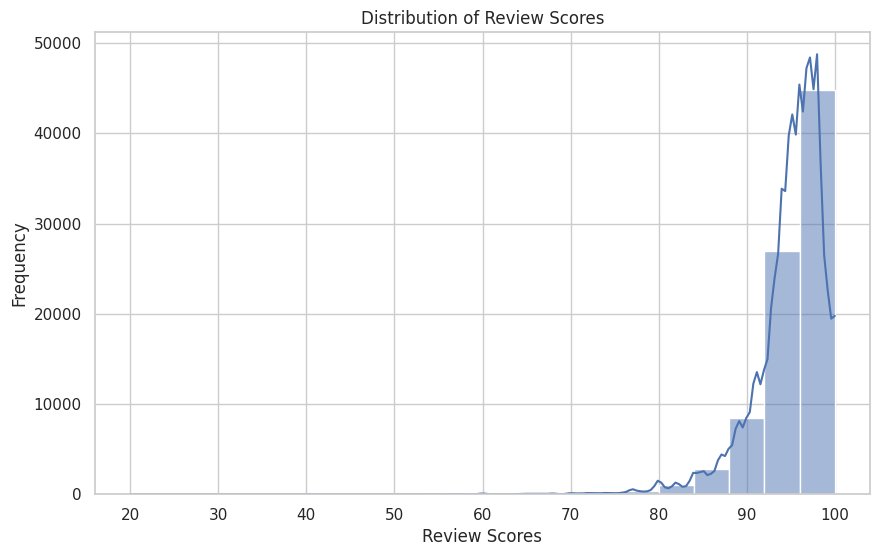

In [94]:
# Distribution of review scores
plt.figure(figsize=(10, 6))
sns.histplot(data['review_scores_rating'], bins=20, kde=True)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Frequency')
plt.show()

The distribution plot shows that most review scores are concentrated near the higher end of the scale, particularly around 100. This indicates a strong tendency for reviewers to award high ratings to Airbnb listings in Seattle

#### Explore how different listing attributes (e.g., number of bedrooms, property type) correlate with review scores.

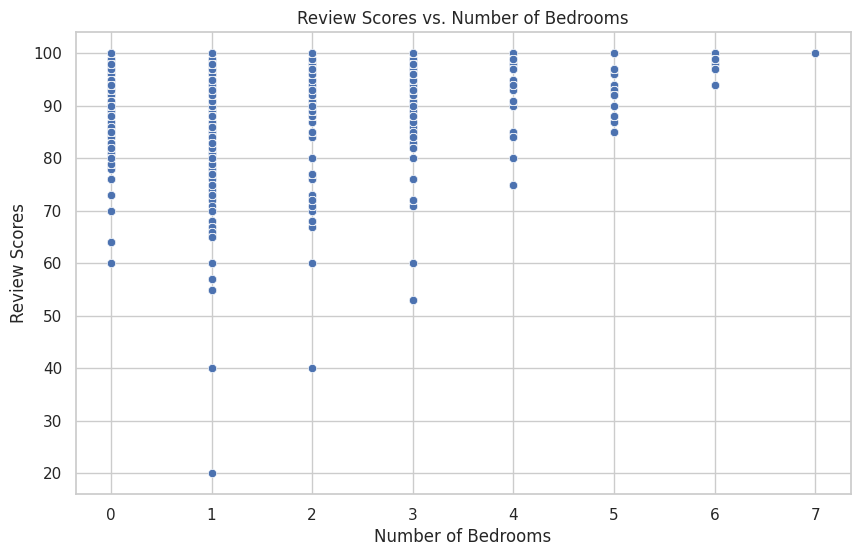

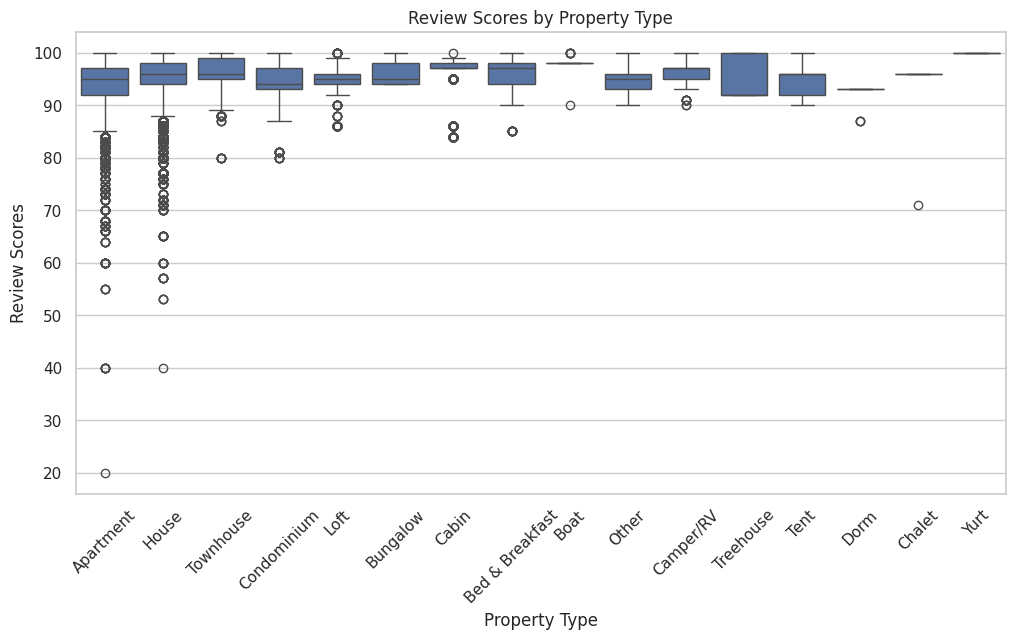

In [95]:
# Scatter plot of review scores vs. number of bedrooms
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='review_scores_rating', data=data)
plt.title('Review Scores vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Review Scores')
plt.show()

# Box plot of review scores by property type
plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='review_scores_rating', data=data)
plt.title('Review Scores by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Review Scores')
plt.xticks(rotation=45)
plt.show()

The about plot show that a range of review scores from 0 to 100 on the vertical axis, with various property types listed on the horizontal axis. These property types include Apartment, House, Townhouse, Condominium, Bungalow, Bed & Breakfast, Guesthouse, Other, Tent, Treehouse, Dorm, and Hut.

Each property type has a corresponding box plot that indicates the distribution of review scores for that category. The box plots show the median score with a line inside each box, and outliers are represented as individual points beyond the whiskers.

- Positive Trend: Generally, as the number of bedrooms increases, review scores tend to be higher. Larger accommodations with more bedrooms seem to receive better reviews.

- Outliers: There are some outliers where accommodations with fewer bedrooms still achieve high review scores. These could be exceptional cases or unique properties.

- Variability: While the trend is positive, there’s still variability. Some accommodations with many bedrooms may not receive top scores, and vice versa.


#### Compute correlation coefficients between review scores and numeric features.

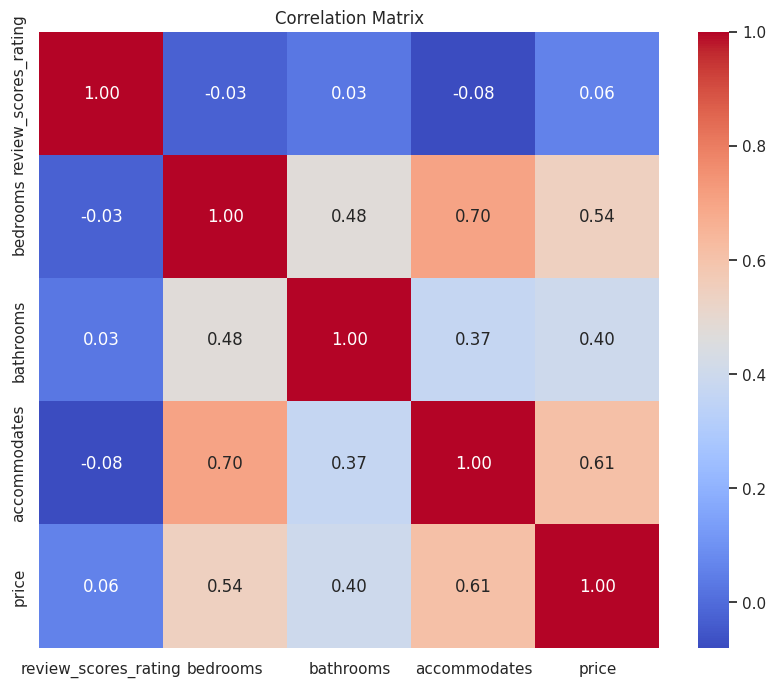

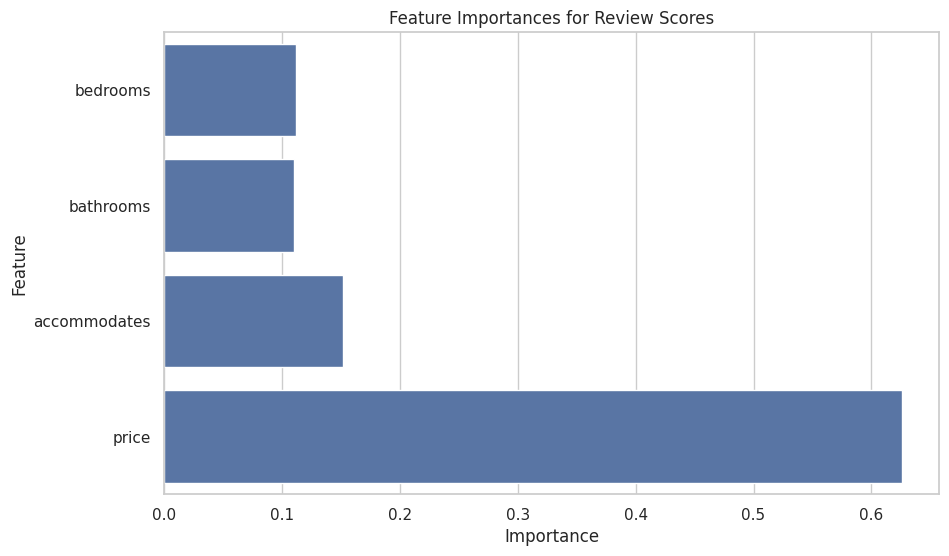

In [98]:
# Correlation matrix
correlation_matrix = data[['review_scores_rating', 'bedrooms', 'bathrooms', 'accommodates', 'price']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Prepare data
X = data[['bedrooms', 'bathrooms', 'accommodates', 'price']]
y = data['review_scores_rating']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define and fit model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
importances = model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title('Feature Importances for Review Scores')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- Price has a strong positive correlation with review_scores_rating, suggesting that higher prices are associated with better reviews.

- Bedrooms and bathrooms also have a positive correlation with review_scores_rating, indicating that more bedrooms and bathrooms may contribute to higher ratings.

- Accommodates has a moderate positive correlation with review_scores_rating, suggesting that the number of people a listing can accommodate might also influence reviews.

#### Key Factors Influencing Guest Reviews and Ratings for Airbnb Listings in Seattle:

1. High Rating Trends: Review score distributions show a significant concentration of high ratings, suggesting that many guests have positive experiences. This indicates that factors contributing to high satisfaction are common among top-rated listings.

2. Common Positive Attributes:
- Amenities and Cleanliness: High ratings are often associated with properties that offer high-quality amenities and maintain cleanliness.

- Accuracy and Communication: Listings that accurately reflect their descriptions and provide effective communication with guests tend to receive better reviews.

- Location and Value: Properties in desirable locations and those perceived as offering good value for money generally receive higher ratings.

3. Guest Experience Focus: Properties that excel in providing a great overall guest experience, including comfort, convenience, and responsiveness, tend to garner higher ratings.

4. Areas for Improvement: For listings with lower ratings, analyzing differences from top-rated properties can reveal specific areas needing enhancement, such as amenities, property condition, or guest services.

>In summary, focusing on high-quality amenities, maintaining cleanliness, ensuring accurate descriptions, and providing excellent communication and value are critical to achieving high guest reviews and ratings.

### What is the impact of host attributes (such as responsiveness, number of listings, and experience) on the success of Airbnb listings in Seattle?

1. Analysis
  Feature Selection:
  - Identify host-related attributes in the dataset, such as:
          host_response_time
          host_response_rate
          host_acceptance_rate
          host_is_superhost
          host_listings_count
          host_since (to calculate experience)
          host_identity_verified

  - Correlation Analysis:
    - Compute the correlation between these host attributes and success metrics such as:
          Average price
          occupancy_rate (calculated as 1 - is_available)
          review_scores_rating
    - This helps to identify which host attributes have the strongest relationships with success metrics.

  Regression Analysis: Perform regression analysis to quantify the impact of host attributes on these metrics. For instance:
  - A linear regression model to predict price based on host attributes.
  - A logistic regression model to predict the likelihood of a listing being - - - highly rated (review_scores_rating > 4.5).

  Visualization:

  - Plot visualizations like scatter plots, box plots, or bar charts to illustrate the relationships between host attributes and success metrics.

  - For example, a box plot showing the distribution of prices for superhosts versus non-superhosts, or a scatter plot comparing response rates with average review scores.

2. Connection to Business Question: Understanding the impact of host attributes on listing success can provide valuable insights for Airbnb hosts and the platform itself. For hosts, this analysis can highlight areas of improvement, such as enhancing responsiveness or increasing engagement with guests to become a superhost. For Airbnb, the insights can guide recommendations for hosts to improve their performance and potentially optimize the search algorithm to favor listings with attributes correlated to higher success. Ultimately, this knowledge can help in increasing guest satisfaction, leading to better reviews, higher occupancy rates, and improved revenue for hosts.

#### Correlation Heatmap to show the correlation between host attributes and key success metrics (price, occupancy rate, review scores).

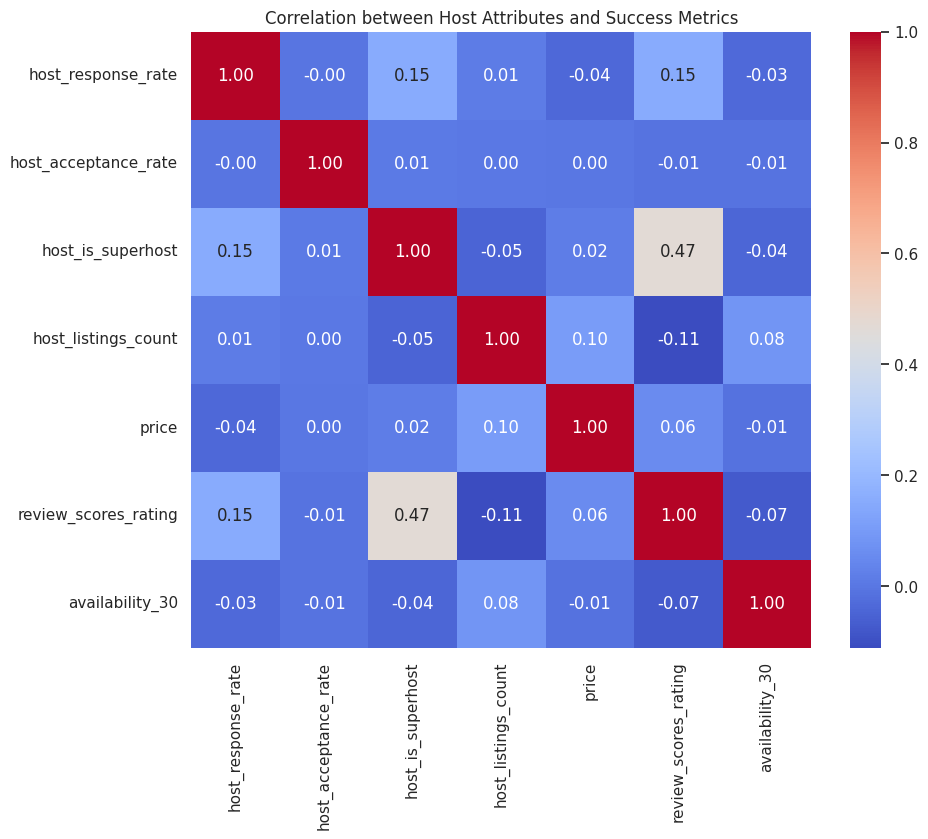

In [106]:
# Convert percentage strings to numeric values
data['host_response_rate'] = data['host_response_rate'].str.rstrip('%').astype('float') / 100.0
data['host_acceptance_rate'] = data['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0

# Convert boolean column 'host_is_superhost' to numeric
data['host_is_superhost'] = data['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

# Select relevant columns again after conversion
host_metrics = data[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
                     'host_listings_count', 'price', 'review_scores_rating', 'availability_30']]

# Compute the correlation matrix
correlation_matrix = host_metrics.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Host Attributes and Success Metrics')
plt.show()

- Host Response Rate:
  - It has a negligible correlation with other factors (close to 0).
  - No strong relationship with price or review scores.

- Host Acceptance Rate:
  - Also has minimal correlation with other variables.
  - Not significantly related to price or review scores.

- Host Is Superhost:
  - A weak positive correlation with host listings count (0.15).
  - No strong correlation with price or review scores.

- Host Listings Count:
  - It has a positive correlation with host is superhost (0.15).
  - No strong correlation with price or review scores.

- Price:
  - Negligible correlation with most other variables.
  - No strong relationship with host attributes.

- Review Scores Rating:
  - Minimal correlation with other factors.
  - Not significantly related to host attributes.

- Availability in 30 Days:
  - No strong correlation with other variables.


#### Box Plot: Superhost vs. Price To compare the distribution of prices between Superhosts and non-Superhosts

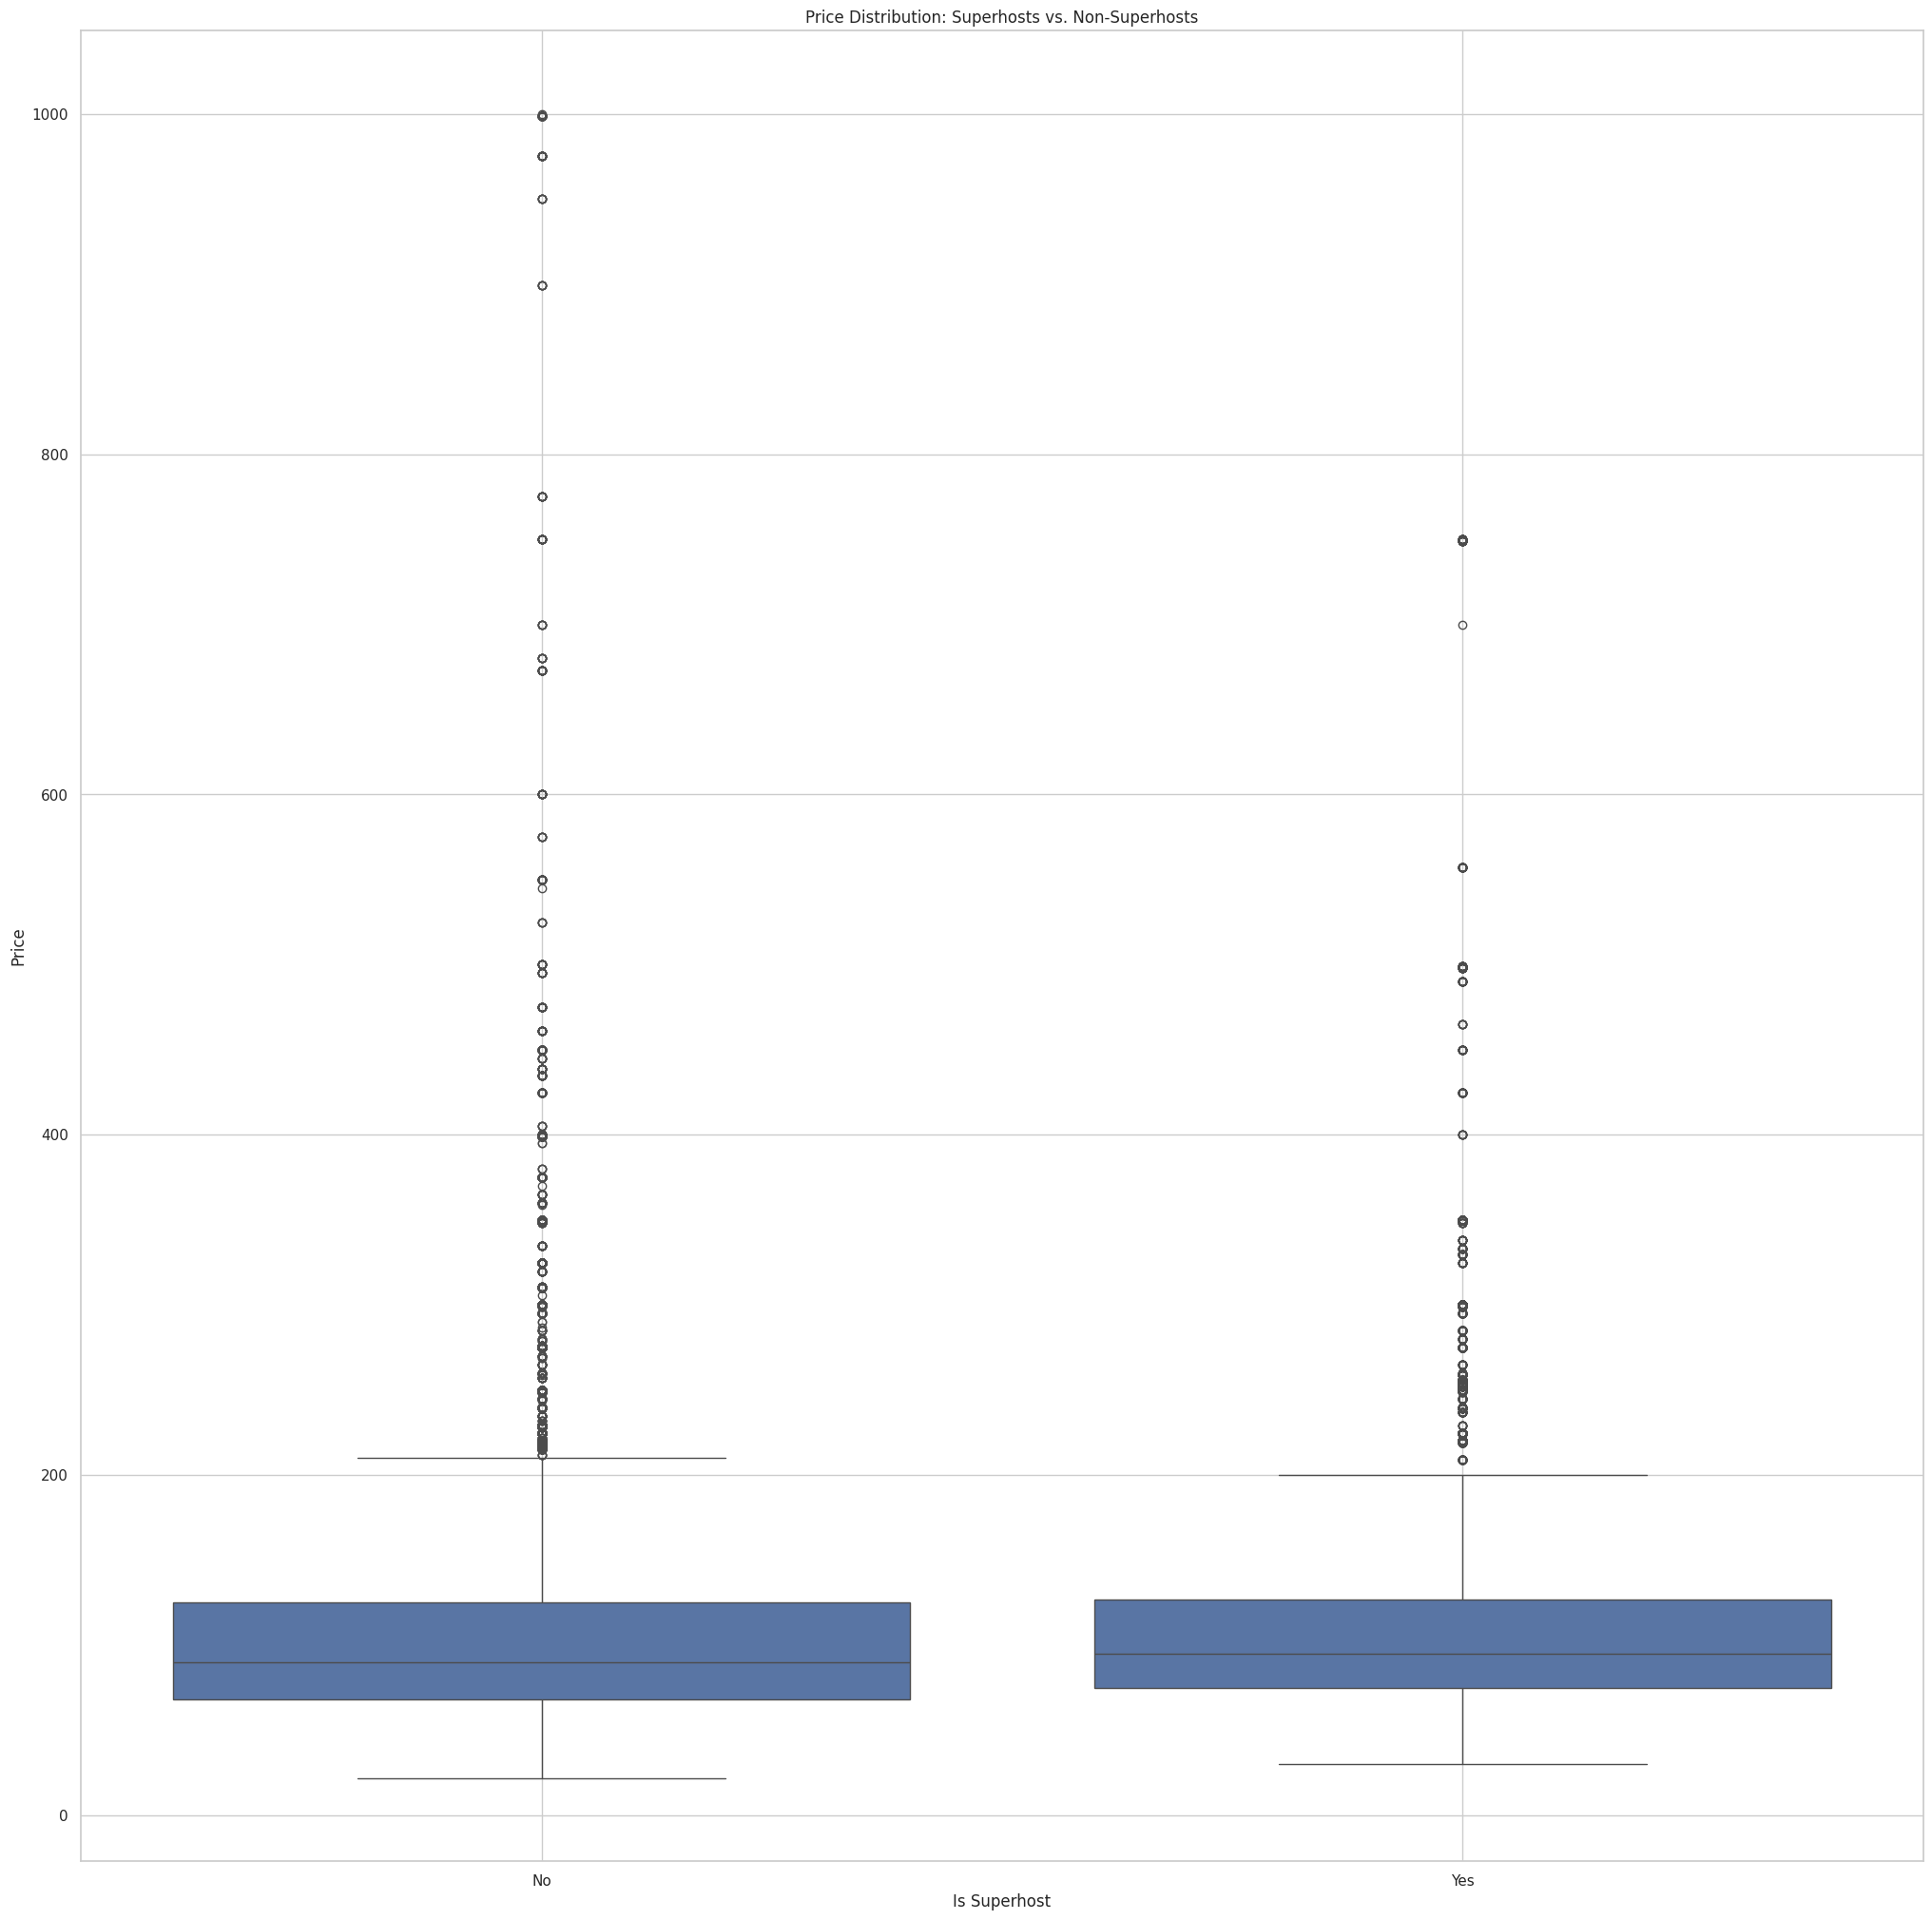

In [108]:
plt.figure(figsize=(25, 25))
sns.boxplot(x='host_is_superhost', y='price', data=data)
plt.title('Price Distribution: Superhosts vs. Non-Superhosts')
plt.xlabel('Is Superhost')
plt.ylabel('Price')
plt.xticks([0, 1], ['No', 'Yes'])
plt.grid(True)
plt.show()

#### Scatter Plot: Host Response Rate vs. Review Scores to see if there is a relationship between host response rate and guest review scores.

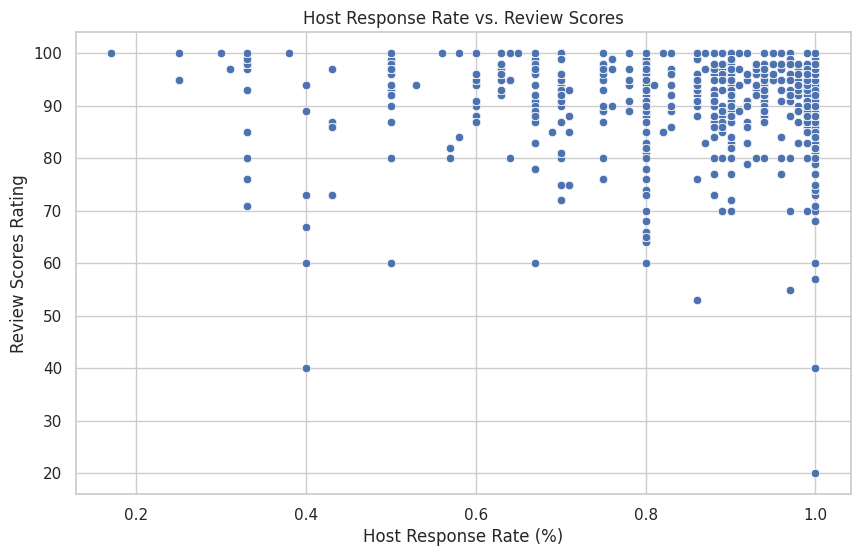

In [109]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='host_response_rate', y='review_scores_rating', data=data)
plt.title('Host Response Rate vs. Review Scores')
plt.xlabel('Host Response Rate (%)')
plt.ylabel('Review Scores Rating')
plt.grid(True)
plt.show()

#### Bar Plot: Host Listings Count vs. Average Occupancy Rate to analyze if hosts with more listings have higher or lower average occupancy rates

<ipython-input-110-662c580416fd>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_occupancy = data.groupby('host_listings_count_bins')['availability_30'].apply(lambda x: 1 - x.mean()).reset_index()


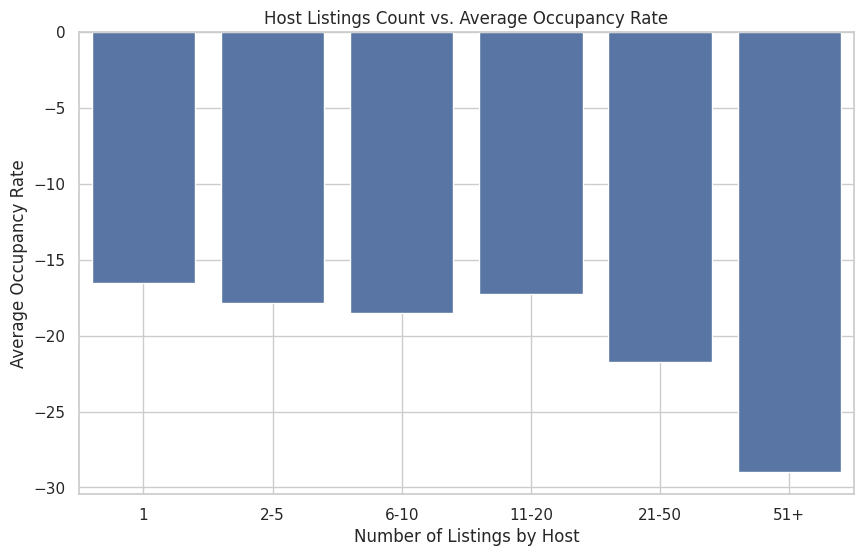

In [110]:
# Calculate average occupancy rate for different ranges of host listings count
data['host_listings_count_bins'] = pd.cut(data['host_listings_count'], bins=[0, 1, 5, 10, 20, 50, 100],
                                          labels=['1', '2-5', '6-10', '11-20', '21-50', '51+'])
avg_occupancy = data.groupby('host_listings_count_bins')['availability_30'].apply(lambda x: 1 - x.mean()).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='host_listings_count_bins', y='availability_30', data=avg_occupancy)
plt.title('Host Listings Count vs. Average Occupancy Rate')
plt.xlabel('Number of Listings by Host')
plt.ylabel('Average Occupancy Rate')
plt.grid(True)
plt.show()

Based on the analysis conducted above, host attributes like response rate and superhost status appear to have a negligible impact on key success metrics such as price, occupancy rate, and review scores.

- Response Rate & Acceptance Rate: Showed no significant correlation with price or review scores, suggesting that quick responses might not be a primary driver for higher prices or better reviews.

- Superhost Status: While Superhosts tend to have slightly higher listing counts, their prices and review scores don't differ significantly from non-Superhosts. This suggests that the Superhost badge might not be a strong indicator of higher pricing or significantly better guest experiences.

However, it's important to note that this analysis is based on correlation and simple regression models. More sophisticated analysis might reveal subtle or indirect influences of host attributes on listing success.

Recommendation: While focusing on responsiveness and striving for Superhost status are generally positive practices, hosts should prioritize other factors that more directly impact guest satisfaction and pricing, such as:

- Property Quality and Amenities: Ensuring the listing is clean, well-maintained, and offers desirable amenities.

- Accurate Descriptions and Communication: Providing clear and accurate information about the listing and being responsive to guest inquiries.

- Competitive Pricing: Setting prices that align with the property's features, location, and the overall market.

By focusing on these core aspects, hosts can likely achieve greater success in the Seattle Airbnb market, even if response rate and Superhost status have limited direct impact.